# Xopt Parallel Examples

Xopt provides methods to parallelize optimizations using Processes, Threads, MPI, and Dask using the `concurrent.futures` interface as defined in  https://www.python.org/dev/peps/pep-3148/ .

In [1]:
from xopt import AsynchronousXopt as Xopt

In [2]:
# Helpers for this notebook
import multiprocessing
N_CPUS=multiprocessing.cpu_count()
N_CPUS

import os

# directory for data. 
os.makedirs("temp", exist_ok=True)

# Notebook printing output
#from xopt import output_notebook
#output_notebook()

# Nicer plotting
%config InlineBackend.figure_format = 'retina'


The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
# Make a proper input file.
YAML = """

max_evaluations: 1000

generator:
  name: cnsga
  output_path: temp
  population_size:  64
  
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    sleep: 0
    random_sleep: 0.1
  
vocs:
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: MINIMIZE, y2: MINIMIZE}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  constants: {a: dummy_constant}

"""
X = Xopt(YAML)
X


            Xopt
________________________________
Version: 0+untagged.1.g8978f87
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [4]:
%%timeit
# Check that the average time is close to random_sleep
X.evaluator.function({"x1": 0.5, "x2": 0.5}, random_sleep = .1)

100 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%time
X.run()

CPU times: user 4.09 s, sys: 23.9 ms, total: 4.11 s
Wall time: 1min 43s


# Processes

In [6]:
from concurrent.futures import ProcessPoolExecutor

In [7]:
%%time
X = Xopt(YAML)

with ProcessPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 4.08 s, sys: 191 ms, total: 4.27 s
Wall time: 26.8 s


1000

# Threads

Continue running, this time with threads.

In [8]:
from concurrent.futures import ThreadPoolExecutor

In [9]:
%%time
X = Xopt(YAML)

with ThreadPoolExecutor(max_workers=N_CPUS) as executor:
    X.evaluator.executor = executor
    X.evaluator.max_workers = N_CPUS
    X.run()
len(X.data)

CPU times: user 3.87 s, sys: 89.6 ms, total: 3.96 s
Wall time: 27.3 s


1000

# MPI 

The `test.yaml` file completely defines the problem. We will also direct the logging to an `xopt.log` file. The following invocation recruits 4 MPI workers to solve this problem.

We can also continue by calling `.save` with a JSON filename. This will write all of previous results into the file.

In [10]:
X = Xopt(YAML)
X.dump('test.yaml') # Write this input to file
!cat test.yaml

data: null
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
    - 0.5
  objectives:
    y1: MINIMIZE
    y2: MINIMIZE
  observables: []
  variables:
    x1:
    - 0.0
    - 3.14159
    x2:
    - 0.0
    - 3.14159


In [11]:
%%time
!mpirun -n 8 python -m mpi4py.futures -m xopt.mpi.run -vv --logfile xopt.log test.yaml

Namespace(input_file='test.yaml', logfile='xopt.log', verbose=2, asynchronous=True)
Parallel execution with 8 workers
Enabling async mode
Initialized generator cnsga
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using selection algorithm: nsga2

            Xopt
________________________________
Version: 0+untagged.1.g8978f87
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0.1
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  crossover_probability: 0.9
  mutation_probability: 1.0
  name: cnsga
  output_path: temp
  population: null
  population_file: null
  population_size: 64
  supports_multi_objective: true
is_done: false
max_evaluations: 1000
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    c1:
    - GREATER_THAN
    - 0.0
    c2:
    - LESS_THAN
   

Xopt is done. Max evaluations 1000 reached.


CPU times: user 289 ms, sys: 73.6 ms, total: 363 ms
Wall time: 24.1 s


In [12]:
!tail xopt.log

2024-03-20T15:27:51+0000 - xopt - INFO - Parallel execution with 8 workers
2024-03-20T15:27:51+0000 - xopt - INFO - Enabling async mode
2024-03-20T15:27:51+0000 - xopt.generator - INFO - Initialized generator cnsga
2024-03-20T15:27:51+0000 - xopt.generators.ga.cnsga - INFO - Created toolbox with 2 variables, 2 constraints, and 2 objectives.
2024-03-20T15:27:51+0000 - xopt.generators.ga.cnsga - INFO -     Using selection algorithm: nsga2
2024-03-20T15:28:11+0000 - xopt.base - INFO - Xopt is done. Max evaluations 1000 reached.


# Dask



In [13]:
from dask.distributed import Client
client = Client()
executor = client.get_executor()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35003,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:34279,Total threads: 1
Dashboard: http://127.0.0.1:39007/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:45567,


In [14]:
%%time
X = Xopt(YAML)
X.evaluator.executor = executor
X.evaluator.max_workers = N_CPUS
X.run()
len(X.data)

CPU times: user 9.75 s, sys: 936 ms, total: 10.7 s
Wall time: 31.4 s


1000

# Load output into Pandas

This algorithm writes two types of files: `gen_{i}.json` with all of the new individuals evaluated in a generation, and `pop_{i}.json` with the latest best population. Xopt provides some functions to load these easily into a Pandas dataframe for further analysis.

In [15]:
import pandas as pd

In [16]:
X.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
1,0.827231,3.135688,dummy_constant,0.827231,3.135688,9.572109,7.053934,0.051116,False
1,0.238139,2.838858,dummy_constant,0.238139,2.838858,7.092857,5.538829,0.035618,False
2,0.229556,2.226282,dummy_constant,0.229556,2.226282,4.016338,3.053189,0.053715,False
3,0.262700,0.859094,dummy_constant,0.262700,0.859094,-0.196519,0.185260,0.105726,False
4,2.925899,2.950317,dummy_constant,2.925899,2.950317,16.165477,11.889040,0.029708,False
...,...,...,...,...,...,...,...,...,...
995,0.739609,0.775518,dummy_constant,0.739609,0.775518,0.055552,0.133323,0.012354,False
996,0.160336,0.692989,dummy_constant,0.160336,0.692989,-0.406124,0.152616,0.095419,False
997,0.931913,0.489660,dummy_constant,0.931913,0.489660,0.096915,0.186656,0.172396,False
998,0.771178,0.844042,dummy_constant,0.771178,0.844042,0.232027,0.191903,0.144364,False


In [17]:
df = pd.concat([X.data, X.vocs.feasibility_data(X.data)], axis=1)
df[df['feasible']]

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error,feasible_c1,feasible_c2,feasible
115,0.358273,1.142089,dummy_constant,0.358273,1.142089,0.417660,0.432365,0.027399,False,True,True,True
120,1.144571,0.579257,dummy_constant,1.144571,0.579257,0.610556,0.421754,0.006756,False,True,True,True
132,1.054257,0.872692,dummy_constant,1.054257,0.872692,0.866291,0.446101,0.092678,False,True,True,True
187,0.833585,0.676965,dummy_constant,0.833585,0.676965,0.161361,0.142596,0.055978,False,True,True,True
194,1.043583,0.486845,dummy_constant,1.043583,0.486845,0.249653,0.295656,0.154845,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.998577,0.593924,dummy_constant,0.998577,0.593924,0.416668,0.257401,0.063000,False,True,True,True
994,0.979222,0.775518,dummy_constant,0.979222,0.775518,0.587780,0.305564,0.000868,False,True,True,True
995,0.739609,0.775518,dummy_constant,0.739609,0.775518,0.055552,0.133323,0.012354,False,True,True,True
997,0.931913,0.489660,dummy_constant,0.931913,0.489660,0.096915,0.186656,0.172396,False,True,True,True


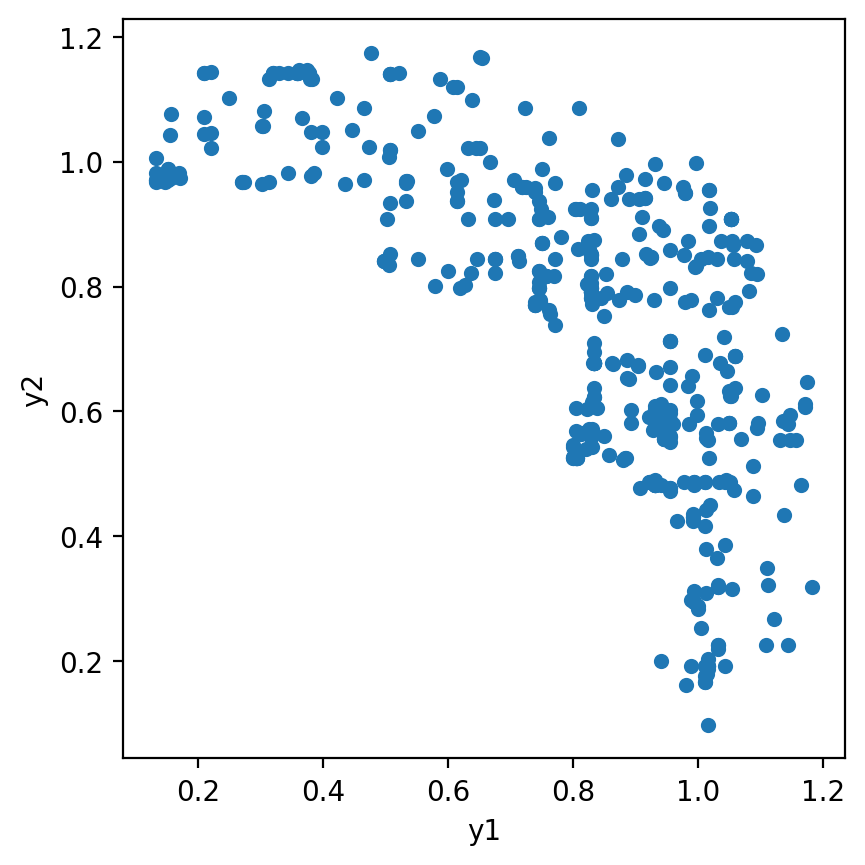

In [18]:
# Plot the feasible ones
feasible_df = df[df["feasible"]]
feasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

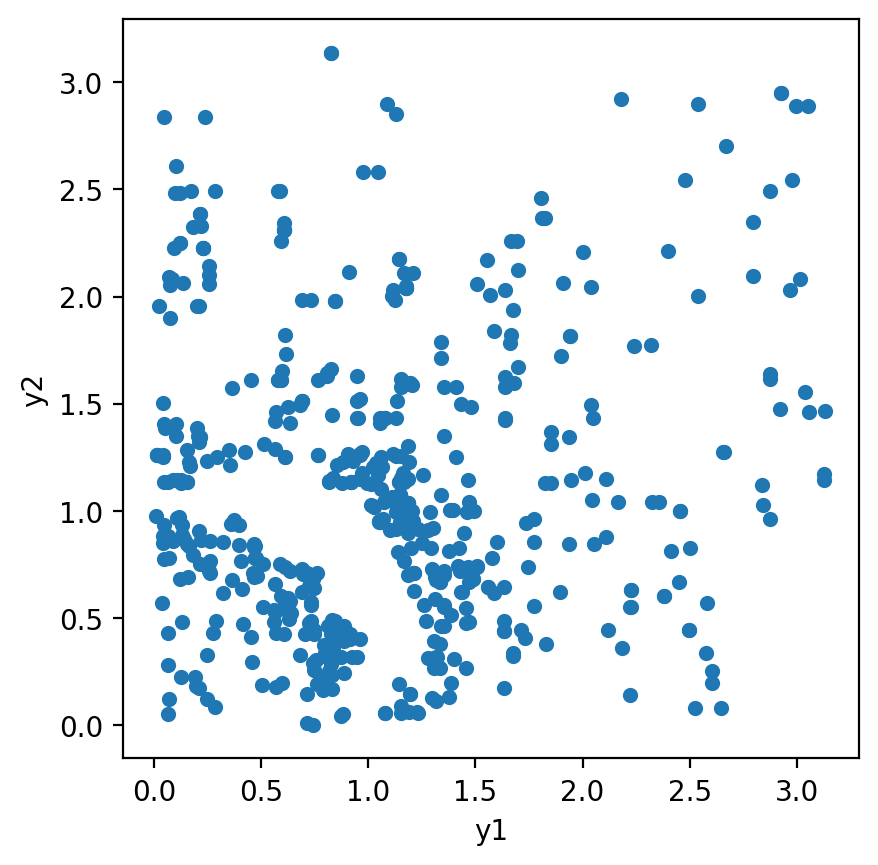

In [19]:
# Plot the infeasible ones
infeasible_df = df[~df["feasible"]]
infeasible_df.plot("y1", "y2", kind="scatter").set_aspect("equal")

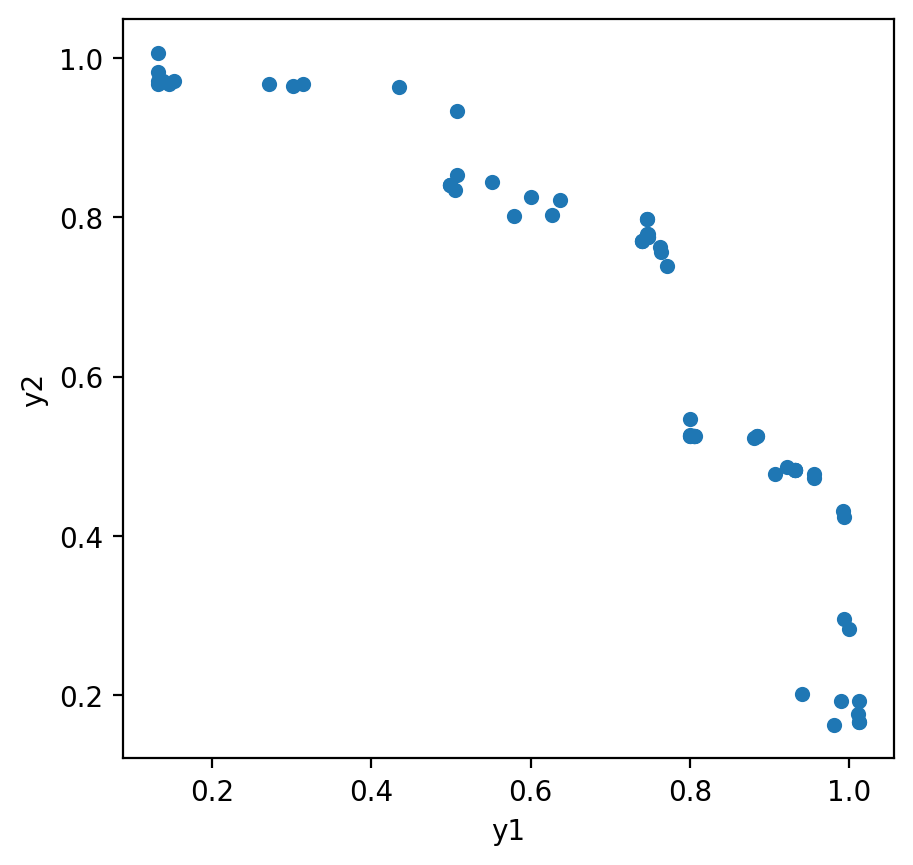

In [20]:
# This is the final population
df1 = X.generator.population
df1.plot("y1", "y2", kind="scatter").set_aspect("equal")

# matplotlib plotting

You can always use matplotlib for customizable plotting

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

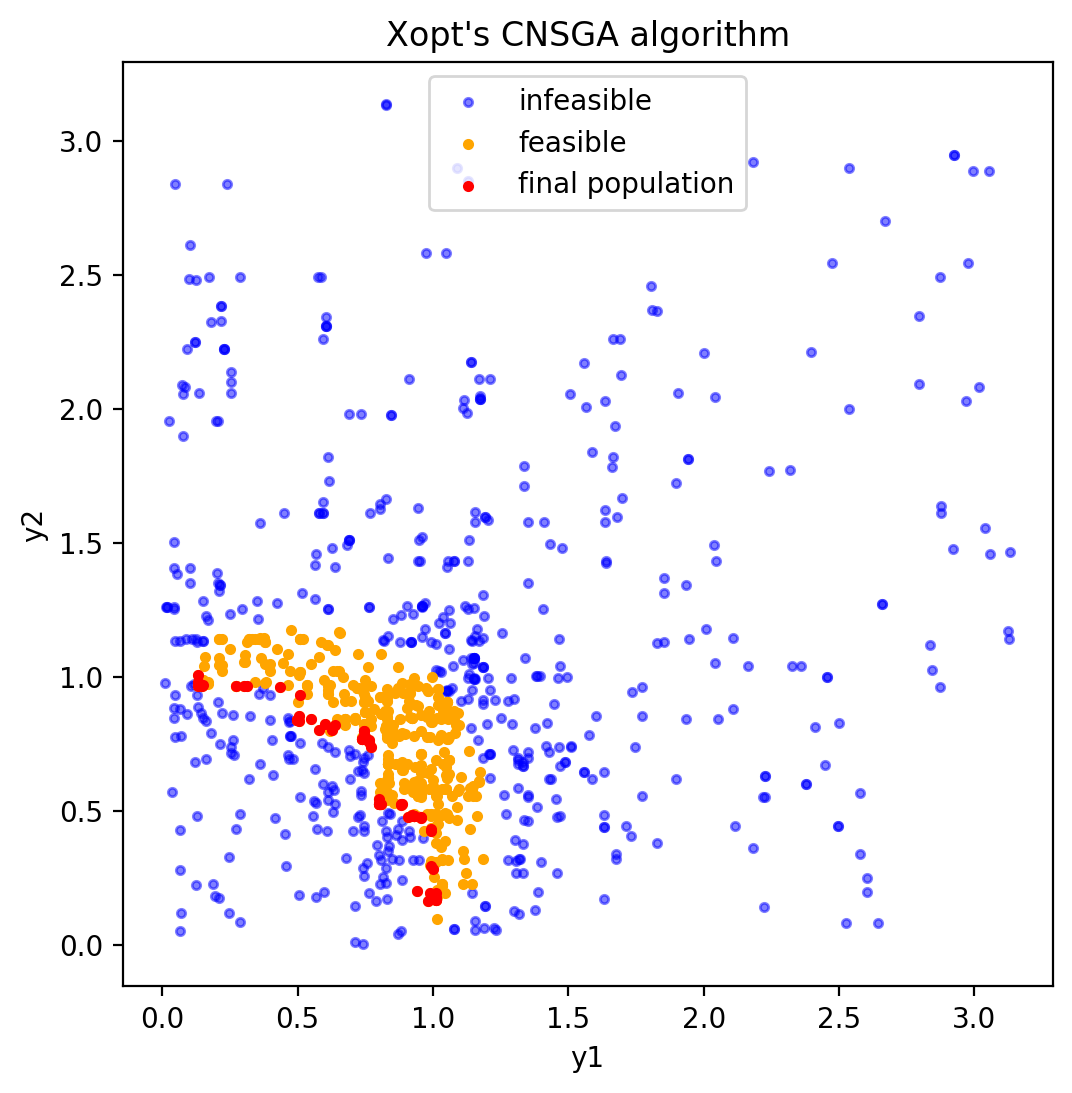

In [22]:
# Extract objectives from output
k1, k2 = "y1", "y2"

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    infeasible_df[k1],
    infeasible_df[k2],
    color="blue",
    marker=".",
    alpha=0.5,
    label="infeasible",
)
ax.scatter(
    feasible_df[k1], feasible_df[k2], color="orange", marker=".", label="feasible"
)
ax.scatter(df1[k1], df1[k2], color="red", marker=".", label="final population")
ax.set_xlabel(k1)
ax.set_ylabel(k2)
ax.set_aspect("auto")
ax.set_title(f"Xopt's CNSGA algorithm")
plt.legend()

In [23]:
# Cleanup
#!rm -r dask-worker-space
!rm -r temp
!rm xopt.log*
!rm test.yaml